In [1]:
import sys

sys.path.append("/home/users/arustam/fwix/operator/lib/python/")
sys.path.append("/home/users/arustam/fwix/propagator/lib/python/")

In [2]:
%load_ext autoreload
%autoreload 2
import SepVector
import CudaOperator
import CudaWEM
from pyVector import superVector
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/numpy/_core/getlimits.py:555: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/_core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.10/dist-packages/numpy/_core/getlimits.py:555: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/_core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


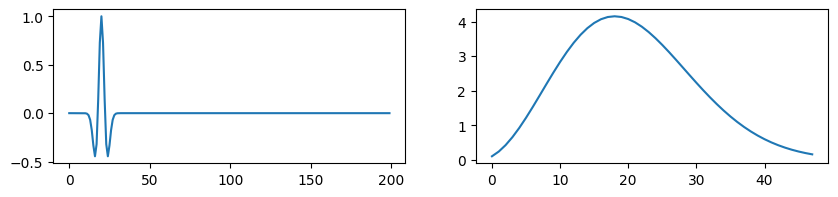

In [3]:
def ricker_wavelet(frequency, Nt, dt, t0=0):
    t = np.linspace(0, (Nt-1)*dt, Nt)
    t_shifted = t - t0
    ricker = (1 - 2 * (np.pi ** 2) * (frequency ** 2) * (t_shifted ** 2)) * np.exp(-(np.pi ** 2) * (frequency ** 2) * (t_shifted ** 2))
    return ricker

# Parameters
frequency = 10  # Ricker wavelet central frequency
Nt = 200    # Length of the wavelet in seconds
dt = 0.01      # Time sampling interval
t0 = 0.2

# Generate Ricker wavelet
wavelet = ricker_wavelet(frequency, Nt, dt, t0=t0)
W = np.fft.fft(wavelet)

df = 1/(Nt*dt)
of = 1.
maxf = 30.
nf = int((maxf-of) / df)

nf = 50
nz = 50
nbatches = [1, 5]
look = 1

f, a = plt.subplots(1,2, figsize=[10,2])
a[0].plot(wavelet, label='Ricker Wavelet')
a[1].plot(np.abs(W[int(of/df):nf]), label="Spectrue")

In [4]:
nf

50

In [5]:
nx = 100
dx = 0.01
ny = 100
dy = 0.01
dz = 0.01

ns = 1;
ds = 1

nxrec = nx
nyrec = ny

slow = SepVector.getSepVector(ns=[nx,ny,nf,nz], ds=[dx, dy, df, dz], os=[0,   0,   of,  0], storage='dataComplex')
# constant
slow[:] = 1.
# add a layer
slow[nz-2:,...] = 2.

# 4 corners
# slow[:,:,:100,:100] = 1/1**2
# slow[:,:,:100,100:] = 1/2**2
# slow[:,:,100:,:100] = 1/3**2
# slow[:,:,100:,100:] = 1/4**2

# add attenuation in the borders
npml = 20
amax = 1e-1
pml = 1j * np.linspace(0,amax,npml) 

# slow[:,:,:npml,:] += -pml[::-1, np.newaxis] 
# slow[:,:,-npml:,:] += -pml[:, np.newaxis]
# slow[:,:,:,:npml] += -pml[::-1]
# slow[:,:,:,-npml:] += -pml

den = slow.clone()
den.set(1)

model = superVector(slow, den)

wfld = SepVector.getSepVector(ns=[nx,ny,nf,ns],ds=[dx,dy,df,ds],os=[0,0,of,0], storage='dataComplex')

n_src_traces = ns
src_traces = SepVector.getSepVector(ns=[nf, n_src_traces],ds=[df, 1],os=[1, 0], storage='dataComplex')
n_rec_traces = nxrec * nyrec * ns
rec_traces = SepVector.getSepVector(ns=[nf, n_rec_traces],ds=[df, 1],os=[1, 0], storage='dataComplex')

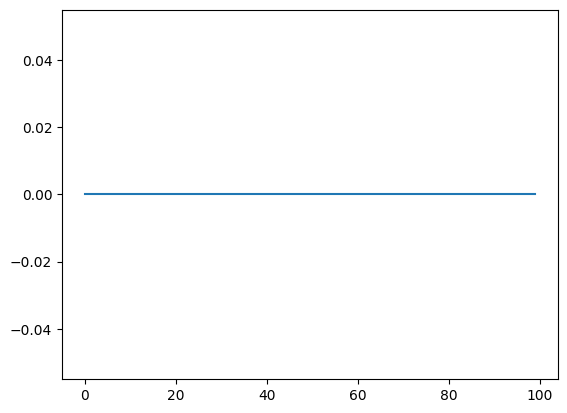

In [6]:
plt.plot(slow[0,0,0,:].imag)

In [7]:
n_rec_traces

10000

In [8]:
sx = np.random.uniform(0, (nx-1)*dx, n_src_traces).astype(np.float32) * 0 + (nx-1)*dx/2
sy = np.random.uniform(0, (ny-1)*dy, n_src_traces).astype(np.float32) * 0 + (ny-1)*dy/2
sz = np.random.uniform(0, (nz-1)*dz, n_src_traces).astype(np.float32) * 0 + 2*dz
s_ids = np.linspace(0, ns-1, ns).astype(int)

rx, ry = np.meshgrid(np.linspace(0, (nx-1)*dx, nxrec), np.linspace(0, (ny-1)*dy, nyrec))
r_ids = s_ids.repeat(rx.size)
rx = np.tile(rx.flatten(), ns)
ry = np.tile(ry.flatten(), ns)
rz = np.zeros(rx.size) + (nz-3)*dz*0

In [9]:
rx.size

10000

In [10]:
import genericIO
par = {
    "nref" : 11,
    "eps" : 0.04,
    "padx" : nx,
    "pady" : ny,
    "taperx" : 0,
    "tapery" : 0,
    "ref_look_ahead" : look
}
par = genericIO.pythonParams(par)

geometry = {
    "sx" : sx, "sy" : sy, "sz" : sz, "s_ids" : s_ids,
    "rx" : rx, "ry" : ry, "rz" : rz, "r_ids" : r_ids,
}

In [11]:
for i in range(n_src_traces):
    src_traces[i, :] = W[:nf]
propOp = CudaWEM.StreamingPropagator(
    model, rec_traces, src_traces, par, geometry, nbatches)

In [12]:
%%timeit -r 1
propOp.forward(False, model, rec_traces)

10.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [13]:
rec_traces.norm()

0.13500632345676422

In [14]:
propOp.get_compression_ratio()

AttributeError: 'StreamingPropagator' object has no attribute 'get_compression_ratio'

In [ ]:
x = sx//dx * dx
y = sy//dy * dy
lx = 1 - (sx-x)/dx
ly = 1 - (sy-y)/dy
lx, ly


In [ ]:
import holoviews as hv 
hv.extension('bokeh')
hv.output(widget_location='bottom')

In [ ]:
snaps = {}
every = 10
pclip = .001

amin = pclip * np.amin(rec_traces[:].real)
amax = pclip * np.amax(rec_traces[:].real)
# wfld_c = np.clip(wfld.real, amin, amax)

for i in range(nf):
    mat = rec_traces[:,i].real
    # only look at the recorded data from the first shot
    mat = mat[:nxrec*nyrec].reshape((nyrec, nxrec))
    snaps[i] = hv.Image(mat, bounds=(0,-nyrec,nxrec,0)).opts(cmap='gray', clim=(-pclip, pclip), aspect=nxrec//nyrec)

In [ ]:
hmap = hv.HoloMap(snaps, kdims='Frequency')
hmap

In [ ]:
hv.Curve(np.abs(rec_traces[2500,:])).opts(aspect=2)

In [ ]:
all_freq = np.zeros((rec_traces.shape[0], Nt), dtype=np.complex64)


all_freq[:,int(of/df):rec_traces.shape[1]+int(of/df)] = rec_traces[:]

time = np.fft.ifft(all_freq, axis=1).real

In [ ]:
snaps = {}
every = 10
pclip = .001

amin = pclip * np.amin(time[:])
amax = pclip * np.amax(time[:])

for i in range(0, Nt, every):
    mat = time[:,i].real
    mat = mat[:nxrec*nyrec].reshape((nyrec, nxrec))
    snaps[i] = hv.Image(mat, bounds=(0,-nyrec,nxrec,0)).opts(cmap='gray', clim=(-pclip, pclip), aspect=nxrec//nyrec)

In [ ]:
hmap = hv.HoloMap(snaps, kdims='Time')
hmap

In [ ]:
mat = time[2100:2800,:].real.T
mat = mat / np.amax(mat)

hv.Image(mat).opts(cmap='gray', clim=(-1, 1), aspect=2)